In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import FixedFormatter
from sklearn.metrics import silhouette_samples
from fcmeans import FCM

from seaborn import scatterplot as scatter
from sklearn.metrics import silhouette_score
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import roc_curve, roc_auc_score

sns.set()
register_matplotlib_converters()

In [2]:
df_raw = pd.read_csv("compas-scores-raw.csv")

In [3]:
df_raw["name"] = df_raw["FirstName"] + " " + df_raw["LastName"]

df_raw["DateOfBirth"] = pd.to_datetime(df_raw["DateOfBirth"], format="%m/%d/%y")
df_raw

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,ScaleSet,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted,name
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,1992-12-05,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0,Kevin Fisher
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,1992-12-05,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0,Kevin Fisher
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,1992-12-05,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0,Kevin Fisher
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,1984-09-16,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0,KEVIN KENDALL
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,1984-09-16,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0,KEVIN KENDALL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60838,65667,79665,72038,Probation,West,James,NaN,Male,African-American,2064-06-21,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,12/31/14 0:00,3,Medium with Override Consideration,8,Risk of Recidivism,0.16,8,High,New,1,0,James West
60839,65667,79665,72038,Probation,West,James,NaN,Male,African-American,2064-06-21,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,12/31/14 0:00,3,Medium with Override Consideration,18,Risk of Failure to Appear,35.00,10,High,New,1,0,James West
60840,68603,79669,72042,PRETRIAL,Ryan,Michael,NaN,Male,Caucasian,1985-02-06,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,12/31/14 0:00,1,Low,7,Risk of Violence,-2.75,2,Low,New,1,0,Michael Ryan
60841,68603,79669,72042,PRETRIAL,Ryan,Michael,NaN,Male,Caucasian,1985-02-06,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,12/31/14 0:00,1,Low,8,Risk of Recidivism,-0.34,5,Medium,New,1,0,Michael Ryan


In [4]:
df_two = pd.read_csv("compas-scores-two-years.csv")

In [5]:
df_two["dob"] = pd.to_datetime(df_two["dob"], format="%Y-%m-%d")
df_two

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,0,7,0,0,0,-1.0,2013-11-22 05:18:27,2013-11-24 02:59:20,13016249CF10A,2013-11-22,NaN,1.0,F,Deliver Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,7,Medium,2013-11-23,Risk of Violence,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,0,3,0,0,0,-1.0,2014-01-31 07:13:54,2014-02-02 04:03:52,14001422CF10A,2014-01-31,NaN,1.0,F,Leaving the Scene of Accident,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,3,Low,2014-02-01,Risk of Violence,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,0,1,0,0,0,-1.0,2014-01-13 05:48:01,2014-01-14 07:49:46,14000581CF10A,2014-01-13,NaN,1.0,F,Aggravated Battery / Pregnant,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2014-01-14,Risk of Violence,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,0,2,0,0,3,-1.0,2014-03-08 08:06:02,2014-03-09 12:18:04,140033

In [6]:
df_raw['name']=df_raw['name'].str.lower()
merged_df = pd.merge(df_two, df_raw, left_on=['name', 'dob'], right_on=['name', 'DateOfBirth'], how='inner')


In [7]:
merged_df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,ScaleSet,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,51601,58102,52796,PRETRIAL,DIXON,KEVON,NaN,Male,African-American,1982-01-22,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/27/13 0:00,1,Low,7,Risk of Violence,-3.07,1,Low,New,1,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,51601,58102,52796,PRETRIAL,DIXON,KEVON,NaN,Male,African-American,1982-01-22,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/27/13 0:00,1,Low,8,Risk of Recidivism,-0.76,3,Low,New,1,0
2,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,51601,58102,52796,PRETRIAL,DIXON,KEVON,NaN,Male,African-American,1982-01-22,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/27/13 0:00,1,Low,18,Risk of Failure to Appear,25.00,6,Medium,New,1,0
3,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,38864,61042,55421,PRETRIAL,Philo,Ed,NaN,Male,African-American,1991-05-14,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,4/14/13 0:00,1,Low,7,Risk of Violence,-2.26,3,Low,New,1,0
4,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,38864,61042,55421,PRETRIAL,

In [8]:
#peszeudonomizálás

drop_columns = ['LastName','FirstName','MiddleName','name','first','last']
merged_df = merged_df.drop(columns = drop_columns)


In [9]:
#duplikáció

merged_df=merged_df.drop_duplicates()

In [10]:
merged_df

,id,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,Person_ID,AssessmentID,Case_ID,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,ScaleSet,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,3,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,51601,58102,52796,PRETRIAL,Male,African-American,1982-01-22,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/27/13 0:00,1,Low,7,Risk of Violence,-3.07,1,Low,New,1,0
1,3,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,51601,58102,52796,PRETRIAL,Male,African-American,1982-01-22,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/27/13 0:00,1,Low,8,Risk of Recidivism,-0.76,3,Low,New,1,0
2,3,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,51601,58102,52796,PRETRIAL,Male,African-American,1982-01-22,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/27/13 0:00,1,Low,18,Risk of Failure to Appear,25.00,6,Medium,New,1,0
3,4,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,38864,61042,55421,PRETRIAL,Male,African-American,1991-05-14,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,4/14/13 0:00,1,Low,7,Risk of Violence,-2.26,3,Low,New,1,0
4,4,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,38864,61042,55421,PRETRIAL,Male,African-American,1991-05-14,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,4/14/13 0:00,1,Low,8,Risk of Recidivism,-0.66,4,Low,New,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [11]:
merged_df = merged_df[
    (merged_df['days_b_screening_arrest'] >= -30.0) & 
    (30.0 >= merged_df['days_b_screening_arrest']) & 
    (merged_df['is_recid'] != -1) &
    (merged_df['c_charge_degree'] != "O") &
    (merged_df['score_text']!= 'N/A')
]

merged_df = merged_df.loc[merged_df.groupby('Person_ID')['screening_date'].idxmax()]
merged_df = merged_df.dropna(subset=["ScoreText"])

In [12]:
merged_df.head(5)

,id,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,Person_ID,AssessmentID,Case_ID,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,ScaleSet,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
552,302,2014-07-13,Female,1981-01-20,35,25 - 45,African-American,0,9,1,0,23,-1.0,2014-07-12 03:02:54,2014-07-14 05:19:00,14009552CF10A,2014-07-12,NaN,1.0,F,Felony Petit Theft,1,15006897CF10A,(F3),NaN,2015-05-27,Felony Petit Theft,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,9,High,2014-07-13,Risk of Violence,9,High,2014-07-13,2014-07-12,2014-07-14,23,1,318,1,1,656,74859,350,Broward County,Female,African-American,1981-01-20,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,7/13/14 0:00,4,High,7,Risk of Violence,-0.67,9,High,Copy,1,0
17277,9710,2014-07-20,Male,1988-11-25,27,25 - 45,African-American,0,5,0,0,8,-1.0,2014-07-19 11:52:29,2014-08-14 05:28:51,14011045CF10A,2014-07-19,NaN,1.0,F,Felony Battery w/Prior Convict,1,14014315CF10A,(F3),56.0,2014-09-02,Felony Battery (Dom Strang),2014-10-28,2015-01-27,NaN,1,14014315CF10A,(F3),2014-09-02,Felony Battery (Dom Strang),Risk of Recidivism,5,Medium,2014-07-20,Risk of Violence,6,Medium,2014-07-20,2014-07-19,2014-08-14,8,25,44,1,1,667,75075,67999,Broward County,Male,African-American,1988-11-25,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,7/20/14 0:00,2,Medium,7,Risk of Violence,-1.55,6,Medium,New,1,0
12945,7312,2014-04-06,Male,1990-05-02,25,25 - 45,Caucasian,0,8,1,0,6,0.0,2014-04-06 02:30:39,2014-04-06 07:45:48,14004746CF10A,2014-04-05,NaN,1.0,F,Crim Use of Personal ID Info,1,16001768MM10A,(M1),NaN,2016-01-11,Battery,NaN,NaN,NaN,1,16001768MM10A,(M1),2016-01-11,Battery,Risk of Recidivism,8,High,2014-04-06,Risk of Violence,6,Medium,2014-04-06,2014-04-06,2014-04-06,6,0,645,1,1,737,71931,430,PRETRIAL,Male,Caucasian,1990-05-02,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,4/6/14 0:00,3,Medium with Override Consideration,7,Risk of Violence,-1.63,6,Medium,Copy,1,0
14781,8304,2013-09-26,Female,1988-07-14,27,25 - 45,Caucasian,0,10,0,0,6,-1.0,2013-09-25 04:05:03,2013-09-26 08:46:37,13013512CF10A,2013-09-25,NaN,1.0,F,Grand Theft (Motor Vehicle),0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,10,High,2013-09-26,Risk of Violence,9,High,2013-09-26,2014-07-09,2014-07-10,6,0,286,0,0,782,65816,472,PRETRIAL,Female,Caucasian,1988-07-14,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,9/26/13 0:00,4,High,7,Risk of Violence,-0.91,9,High,Copy,1,0
8097,4530,2013-11-27,Male,1990-07-15,25,25 - 45,Other,0,2,0,0,2,0.0,2013-11-27 12:32:45,2013-11-27 02:52:06,13016493CF10A,2013-11-26,NaN,1.0,F,"Poss3,4 Methylenedioxymethcath",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,2,Low,2013-11-27,Risk of Violence,3,Low,2013-11-27,2015-04-10,2015-04-11,2,0,499,0,0,869,67920,562,PRETRIAL,Male,Other,1990-07-15,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,11/27/13 0:00,1,Low,7,Risk of Violence,-2.37,3,Low,Copy,1,0


In [13]:
data = {
    'Group': merged_df['DecileScore'],  # Csoportosítási eredmény (pl. klaszter index)
    'is_recid': merged_df['is_recid']  # is_recid változó értékei
}

df_sum_origin = pd.DataFrame(data)

# Kimutatás készítése: Csoportonkénti is_recid értékek számlálása és átlaga
summary_origin = df_sum_origin.groupby('Group')['is_recid'].agg(['count', 'mean']).reset_index()
summary_origin.columns = ['Group', 'Count', 'Mean_is_recid']

In [14]:
print(summary_origin)

   Group  Count  Mean_is_recid
0      1    850       0.281176
1      2    788       0.416244
2      3    745       0.488591
3      4    623       0.540931
4      5    541       0.591497
5      6    476       0.611345
6      7    363       0.663912
7      8    247       0.777328
8      9    221       0.823529
9     10     95       0.778947


DecileScore          1      2      3      4      5      6      7      8   \
race                                                                       
African-American  278.0  369.0  390.0  352.0  318.0  309.0  263.0  184.0   
Asian              10.0    4.0    1.0    4.0    0.0    2.0    0.0    1.0   
Caucasian         361.0  275.0  265.0  194.0  147.0  115.0   72.0   42.0   
Hispanic          114.0   80.0   55.0   39.0   52.0   30.0   14.0   14.0   
Native American     2.0    1.0    0.0    3.0    0.0    0.0    1.0    0.0   
Other              85.0   59.0   34.0   31.0   24.0   20.0   13.0    6.0   

DecileScore          9     10  
race                           
African-American  163.0  72.0  
Asian               0.0   0.0  
Caucasian          39.0  15.0  
Hispanic           11.0   5.0  
Native American     2.0   0.0  
Other               6.0   3.0  


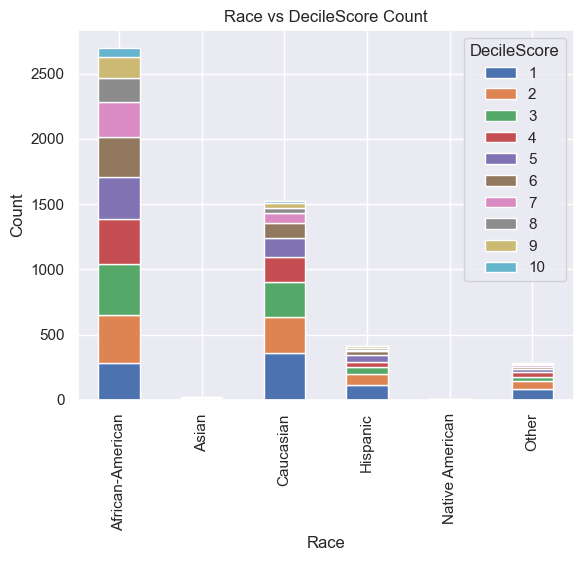

In [15]:

cluster_race_counts = merged_df.groupby(['race', 'DecileScore']).size().reset_index(name='Count')

# Pivot tábla készítése a jobb olvashatóság érdekében
pivot_table = cluster_race_counts.pivot(index='race', columns='DecileScore', values='Count').fillna(0)

# Kimenet megtekintése
print(pivot_table)

pivot_table.plot(kind='bar', stacked=True)

plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Race vs DecileScore Count')
plt.legend(title='DecileScore')



In [17]:
not_biased_columns = ['age','juv_fel_count', 'juv_misd_count', 'juv_other_count','priors_count','days_b_screening_arrest','c_charge_degree','c_charge_desc','r_charge_degree','r_days_from_arrest','r_offense_date','violent_recid','vr_charge_degree','vr_offense_date','in_custody','out_custody','event','race']

biased_but_needed_columns = ['sex', 'race', 'MaritalStatus', "CustodyStatus", 'LegalStatus','two_year_recid','DecileScore']

merged_colums = ['age','juv_fel_count', 'juv_misd_count', 'juv_other_count','priors_count','days_b_screening_arrest','c_charge_degree','c_charge_desc','is_recid','r_charge_degree','r_days_from_arrest','r_offense_date','violent_recid','vr_charge_degree','vr_offense_date','in_custody','out_custody','event','two_year_recid','sex', 'race', 'MaritalStatus', "CustodyStatus", 'LegalStatus','DecileScore']

In [18]:
df = merged_df[not_biased_columns]

In [19]:
df['r_offense_date'] = pd.to_datetime(df['r_offense_date'])
df['in_custody'] = pd.to_datetime(df['in_custody'])
df['vr_offense_date'] = pd.to_datetime(df['vr_offense_date'])
df['out_custody'] = pd.to_datetime(df['out_custody'])


df['r_offense_date'] = pd.to_numeric(df['r_offense_date'], errors='coerce').fillna(0).astype(int)
df['in_custody'] = pd.to_numeric(df['in_custody'], errors='coerce').fillna(0).astype(int)
df['vr_offense_date'] = pd.to_numeric(df['vr_offense_date'], errors='coerce').fillna(0).astype(int)
df['out_custody'] = pd.to_numeric(df['out_custody'], errors='coerce').fillna(0).astype(int)


C:\Users\molar\AppData\Local\Temp\ipykernel_9036\2562195509.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r_offense_date'] = pd.to_datetime(df['r_offense_date'])
C:\Users\molar\AppData\Local\Temp\ipykernel_9036\2562195509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['in_custody'] = pd.to_datetime(df['in_custody'])
C:\Users\molar\AppData\Local\Temp\ipykernel_9036\2562195509.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [20]:
df['days_b_screening_arrest'] = df['days_b_screening_arrest'].astype(int)

C:\Users\molar\AppData\Local\Temp\ipykernel_9036\767232123.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days_b_screening_arrest'] = df['days_b_screening_arrest'].astype(int)


In [21]:
df

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_charge_degree,c_charge_desc,r_charge_degree,r_days_from_arrest,r_offense_date,violent_recid,vr_charge_degree,vr_offense_date,in_custody,out_custody,event,race
552,35,0,1,0,23,-1,F,Felony Petit Theft,(F3),NaN,588906496,NaN,NaN,0,296288256,877068288,1,African-American
17277,27,0,0,0,8,-1,F,Felony Battery w/Prior Convict,(F3),56.0,-1783300096,NaN,(F3),-1783300096,181534720,-858259456,1,African-American
12945,25,0,1,0,6,0,F,Crim Use of Personal ID Info,(M1),NaN,516227072,NaN,(M1),516227072,45744128,45744128,1,Caucasian
14781,27,0,0,0,6,-1,F,Grand Theft (Motor Vehicle),NaN,NaN,0,NaN,NaN,0,1572601856,-284491776,0,Caucasian
8097,25,0,0,0,2,0,F,"Poss3,4 Methylenedioxymethcath",NaN,NaN,0,NaN,NaN,0,1972961280,115867648,0,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15240,30,0,0,0,0,-1,F,Possession of Cocaine,(F3),1.0,1061945344,NaN,NaN,0,-2071461888,-781123584,1,African-American
12459,26,0,1,0,6,-1,F,Poss Pyrrolidinovalerophenone,(F3),1.0,1492910080,NaN,(F3),1492910080,-1877016576,-715456512,1,African-American
13260,30,0,0,0,3,-1,M,Battery,(F3),0.0,-572653568,NaN,NaN,0,-572653568,1865220096,1,Hispanic
10560,34,0,0,0,0,-1,F,Poss Pyrrolidinovalerophenone,(F3),NaN,-1841954816,NaN,NaN,0,560857088,-1174470656,1,Caucasian


In [22]:
print(df.dtypes)

age                          int64
juv_fel_count                int64
juv_misd_count               int64
juv_other_count              int64
priors_count                 int64
days_b_screening_arrest      int32
c_charge_degree             object
c_charge_desc               object
r_charge_degree             object
r_days_from_arrest         float64
r_offense_date               int32
violent_recid              float64
vr_charge_degree            object
vr_offense_date              int32
in_custody                   int32
out_custody                  int32
event                        int64
race                        object
dtype: object


In [23]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
label_encoders = {}
for column in ['c_charge_degree', 'c_charge_desc', 'r_charge_degree', 'vr_charge_degree','race']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

# NaN értékek kezelése (itt nullára állítjuk)
df = df.fillna(0)


C:\Users\molar\AppData\Local\Temp\ipykernel_9036\2872027040.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = le.fit_transform(df[column].astype(str))
C:\Users\molar\AppData\Local\Temp\ipykernel_9036\2872027040.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = le.fit_transform(df[column].astype(str))
C:\Users\molar\AppData\Local\Temp\ipykernel_9036\2872027040.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [24]:
scaled_df = preprocessing.scale(df)

C:\Users\molar\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


In [25]:
fcm = FCM(n_clusters=10, random_state=42, max_iter=2)
fcm.fit(scaled_df)

fcm_centers = fcm.centers
u = pd.DataFrame(fcm.u)
fcm_labels  = fcm.u.argmax(axis=1)

y_pred_fuzzy = fcm.predict(scaled_df) +1

print("FCM predikciók")
print(fcm.u[:10])
print()
print("Becsült értékek")
for i in range(10):
    print(y_pred_fuzzy[i])

FCM predikciók
[[0.09973193 0.10013339 0.09996385 0.09990586 0.10010071 0.10017638
  0.0999495  0.09986045 0.10022109 0.09995684]
 [0.09981954 0.10003168 0.09999091 0.09986087 0.10011299 0.10027562
  0.10001559 0.0999192  0.10002909 0.09994452]
 [0.09909861 0.10009828 0.10005904 0.09995109 0.10011441 0.10061028
  0.09978024 0.10013503 0.10020033 0.09995269]
 [0.10047984 0.09945428 0.0998963  0.10042698 0.09996444 0.09914949
  0.10001995 0.1002903  0.10060406 0.09971437]
 [0.10005196 0.09975921 0.10019696 0.1002283  0.10003797 0.09962821
  0.09998418 0.10016047 0.10001909 0.09993364]
 [0.09952923 0.10011592 0.10002517 0.10002915 0.1001895  0.10042111
  0.09954318 0.10008968 0.10005355 0.10000352]
 [0.10048345 0.10005416 0.0996478  0.09958594 0.09994867 0.0997816
  0.10033259 0.09983846 0.10037843 0.09994891]
 [0.0999255  0.10008424 0.0999528  0.0998655  0.10004811 0.10007062
  0.09998635 0.09991958 0.1001521  0.0999952 ]
 [0.10002631 0.10026132 0.09983632 0.09939742 0.10001525 0.1002413

In [26]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(scaled_df, fcm_labels)

print("Silhouette Score for Fuzzy C-Means Clustering:", sil_score)


Silhouette Score for Fuzzy C-Means Clustering: -0.020219309691292577


In [27]:
y_true = merged_df['DecileScore']

In [28]:
data = {
    'Group': y_pred_fuzzy,  # Csoportosítási eredmény (pl. klaszter index)
    'is_recid': merged_df['is_recid']  # is_recid változó értékei
}

df_sum = pd.DataFrame(data)

# Kimutatás készítése: Csoportonkénti is_recid értékek számlálása és átlaga
summary = df_sum.groupby('Group')['is_recid'].agg(['count', 'mean']).reset_index()
summary.columns = ['Group', 'Count', 'Mean_is_recid']

In [29]:
print(summary)

   Group  Count  Mean_is_recid
0      1   1848       0.036255
1      2    184       1.000000
2      3     97       0.814433
3      4    496       0.385081
4      5     30       0.900000
5      6   1360       1.000000
6      7    367       0.732970
7      8     69       0.275362
8      9    460       0.782609
9     10     38       0.315789


In [30]:
df_c = df.copy()
df_c['DecileScore'] = y_pred_fuzzy
for column, le in label_encoders.items():
    df_c[column] = le.inverse_transform(df_c[column])
cluster_race_counts = df_c.groupby(['race', 'DecileScore']).size().reset_index(name='Count')

# Pivot tábla készítése a jobb olvashatóság érdekében
pivot_table = cluster_race_counts.pivot(index='race', columns='DecileScore', values='Count').fillna(0)

# Kimenet megtekintése
print(pivot_table)



DecileScore          1     2     3      4     5      6      7     8      9   \
race                                                                          
African-American  872.0  77.0   5.0  281.0   5.0  805.0  250.0  16.0  384.0   
Asian              14.0   1.0   0.0    1.0   0.0    5.0    0.0   0.0    1.0   
Caucasian         663.0  79.0  24.0  156.0  11.0  396.0   95.0  31.0   64.0   
Hispanic          198.0  17.0  14.0   39.0   5.0   97.0   20.0   8.0   10.0   
Native American     5.0   1.0   0.0    0.0   1.0    2.0    0.0   0.0    0.0   
Other              96.0   9.0  54.0   19.0   8.0   55.0    2.0  14.0    1.0   

DecileScore         10  
race                    
African-American   3.0  
Asian              0.0  
Caucasian          6.0  
Hispanic           6.0  
Native American    0.0  
Other             23.0  


Második modell

In [31]:
kmeans = KMeans(n_clusters=10, init='random', n_init=100, max_iter=1000, random_state=42)
kmeans.fit(scaled_df)
y_pred = kmeans.predict(scaled_df)+1

y_pred[:30]

array([ 7, 10,  9,  4,  4,  7,  2, 10,  2,  7,  2,  5,  2,  4,  8,  6,  7,
        5,  6,  7,  6,  4,  1,  2,  7,  6,  4,  6,  8,  4])

In [32]:
kmeans_sil_score = silhouette_score(scaled_df, y_pred)

print("Silhouette Score for KMeans Clustering:", kmeans_sil_score)

Silhouette Score for KMeans Clustering: 0.11098165543678233


In [33]:
data = {
    'Group': y_pred,  # Csoportosítási eredmény (pl. klaszter index)
    'is_recid': merged_df['is_recid']  # is_recid változó értékei
}

df_sum = pd.DataFrame(data)

# Kimutatás készítése: Csoportonkénti is_recid értékek számlálása és átlaga
summary = df_sum.groupby('Group')['is_recid'].agg(['mean']).reset_index()
summary.columns = ['Group', 'Mean_is_recid']

In [34]:
print(summary)

   Group  Mean_is_recid
0      1       0.814815
1      2       1.000000
2      3       1.000000
3      4       0.128450
4      5       0.096241
5      6       0.139059
6      7       1.000000
7      8       0.419162
8      9       1.000000
9     10       1.000000


In [35]:
df_c = df.copy()
df_c['Cluster'] = y_pred

for column, le in label_encoders.items():
    df_c[column] = le.inverse_transform(df_c[column])


cluster_race_counts = df_c.groupby(['race', 'Cluster']).size().reset_index(name='Count')

# Pivot tábla készítése a jobb olvashatóság érdekében
pivot_table = cluster_race_counts.pivot(index='race', columns='Cluster', values='Count').fillna(0)

# Kimenet megtekintése
print(pivot_table)



Cluster             1      2     3      4      5      6      7     8      9   \
race                                                                           
African-American  89.0  489.0  33.0  591.0  263.0  378.0  473.0  70.0  175.0   
Asian              0.0    3.0   0.0    2.0    6.0    8.0    1.0   0.0    0.0   
Caucasian         14.0  215.0  18.0  257.0  250.0  375.0  202.0  72.0   65.0   
Hispanic           2.0   51.0   3.0   61.0   71.0  130.0   49.0  19.0   12.0   
Native American    0.0    0.0   1.0    0.0    3.0    4.0    0.0   0.0    0.0   
Other              3.0   24.0   1.0   31.0   72.0   83.0   32.0   6.0   13.0   

Cluster              10  
race                     
African-American  137.0  
Asian               2.0  
Caucasian          57.0  
Hispanic           16.0  
Native American     1.0  
Other              16.0  


Harmadik modell

In [36]:
kmeans_per_k = [KMeans(
    n_clusters = k, 
    init = 'k-means++', 
    n_init = 10, 
    random_state = 42
    ).fit(scaled_df) for k in range(1,20)]



In [37]:
for i, k in enumerate((7, 8, 9, 10), start=1):
    y_pred_k_means = kmeans_per_k[k-1].labels_+1
    
    

In [38]:
kmeansplus_sil_score = silhouette_score(scaled_df, y_pred_k_means)

print("Silhouette Score for KMeans++ Clustering:", kmeansplus_sil_score)

Silhouette Score for KMeans++ Clustering: 0.12421095386738176


In [39]:
var_ratio = 2
pca = PCA(n_components=var_ratio)
pca.fit(scaled_df)
pca_data = pca.transform(scaled_df)

loading_scores = pd.Series(pca.components_[0])
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

loadings = pd.Series(loading_scores)
factors = pd.Series(df.columns)
print(pd.concat([loadings, factors], axis=1))

           0                        1
0  -0.125430                      age
1   0.172567            juv_fel_count
2   0.252701           juv_misd_count
3   0.203141          juv_other_count
4   0.365802             priors_count
5   0.080168  days_b_screening_arrest
6  -0.186519          c_charge_degree
7   0.140851            c_charge_desc
8  -0.519083          r_charge_degree
9   0.108530       r_days_from_arrest
10  0.021834           r_offense_date
11 -0.000000            violent_recid
12 -0.346643         vr_charge_degree
13  0.054555          vr_offense_date
14  0.005948               in_custody
15 -0.003348              out_custody
16  0.457023                    event
17 -0.201845                     race


In [40]:
data = {
    'Group': y_pred_k_means,  # Csoportosítási eredmény (pl. klaszter index)
    'is_recid': merged_df['is_recid']  # is_recid változó értékei
}

df_sum = pd.DataFrame(data)

# Kimutatás készítése: Csoportonkénti is_recid értékek számlálása és átlaga
summary = df_sum.groupby('Group')['is_recid'].agg(['mean']).reset_index()
summary.columns = ['Group', 'Mean_is_recid']

In [41]:
print(summary)

   Group  Mean_is_recid
0      1       0.151573
1      2       1.000000
2      3       1.000000
3      4       1.000000
4      5       0.415663
5      6       1.000000
6      7       0.806452
7      8       0.818182
8      9       0.089420
9     10       0.666667


In [42]:
df_c = df.copy()
df_c['Csoport'] = y_pred_k_means
for column, le in label_encoders.items():
    df_c[column] = le.inverse_transform(df_c[column])
cluster_race_counts = df_c.groupby(['race', 'Csoport']).size().reset_index(name='Count')

# Pivot tábla készítése a jobb olvashatóság érdekében
pivot_table = cluster_race_counts.pivot(index='race', columns='Csoport', values='Count').fillna(0)

# Kimenet megtekintése
print(pivot_table)



Csoport              1      2     3      4     5      6     7     8      9   \
race                                                                          
African-American  424.0  549.0  33.0  510.0  70.0  173.0  54.0  44.0  779.0   
Asian               8.0    5.0   0.0    2.0   0.0    0.0   0.0   0.0    7.0   
Caucasian         394.0  235.0  18.0  232.0  71.0   63.0   6.0   8.0  453.0   
Hispanic          135.0   60.0   3.0   52.0  19.0   12.0   1.0   1.0  125.0   
Native American     4.0    1.0   1.0    1.0   0.0    0.0   0.0   0.0    2.0   
Other              84.0   34.0   1.0   39.0   6.0   14.0   1.0   2.0   99.0   

Csoport             10  
race                    
African-American  62.0  
Asian              0.0  
Caucasian         45.0  
Hispanic           6.0  
Native American    0.0  
Other              1.0  
